In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import json
import requests
from datetime import datetime
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap

ModuleNotFoundError: No module named 'matplotlib'

## Traer las series de cada provincia

In [2]:
def get_series(df_con_ids):
    today = datetime.today().strftime('%Y-%m-%d')
    series_req = ''
    columns = ['fecha']
    for index,prov in df_con_ids.iterrows():
        # print(type(prov.loc['serie_titulo']))
        columns.append(prov.loc['serie_titulo'])
        series_req += prov.loc['serie_id']+','
    series_req = series_req[:-1]
    response = requests.get(url=f'https://apis.datos.gob.ar/series/api/series?ids={series_req}&start_date=2009-01-01&end_date={today}&limit=5000')
    res = json.loads(response.text)
    empleo_registrado = pd.DataFrame(res['data'],columns=columns)
    series_req = ''
    columns = ['fecha']
    for index,prov in df_con_ids.iterrows():
        # print(type(prov.loc['serie_titulo']))
        columns.append(prov.loc['serie_titulo'] + '_sin_estacionalidad')
        series_req += prov.loc['serie_id_sin_estacionalidad']+','
    series_req = series_req[:-1]
    response = requests.get(url=f'https://apis.datos.gob.ar/series/api/series?ids={series_req}&start_date=2009-01-01&end_date={today}&limit=5000')
    res_s = json.loads(response.text)
    empleo_registrado_s = pd.DataFrame(res_s['data'],columns=columns)
    return empleo_registrado.join(empleo_registrado_s.set_index('fecha'),on='fecha').set_index('fecha')



In [40]:
# df = pd.read_csv('empleo_prov.csv',delimiter=';')
# nombres_provincias = df['serie_titulo'].unique()

In [ ]:
# empleo = get_series(df)
# for p in nombres_provincias:
#     empleo[f'Interanual_{p} (%)'] = empleo[p].pct_change(12)
#     empleo[f'Interanual_{p}'] = empleo[p].diff(12)
# empleo.to_excel('trabajo_por_provincia.xlsx')
# empleo = pd.read_excel('trabajo_por_provincia.xlsx') #Si hay un excel mas actualizado, corroborar las columnas

In [ ]:
interanuales = [col for col in empleo.iloc[-1].index if 'Interanual' in col]
def buscar_provincia(string,provincias):
    for p in provincias:
        if p in string:
            return p
# interanual = pd.DataFrame(empleo.iloc[-1][interanuales])
interanual = pd.DataFrame(empleo.iloc[-1])
# interanual['provincia'] = interanual.index.map(lambda x: x.split()[:-1].split('_')[1])
# interanual.to_csv('test.csv',index=True)
# interanual['provincia'] = interanual.index.apply(lambda x: x.split()[0].split('_')[1])
interanual['provincia'] = interanual.index.map(lambda x: buscar_provincia(x,nombres_provincias))
interanual = interanual.loc[interanuales]

In [ ]:
porcentual = interanual[interanual.index.str.contains('%')].set_index('provincia')
abs = interanual[~(interanual.index.str.contains('%'))].set_index('provincia')
porcentual.columns = ['Interanual %']
abs.columns = ['Interanual']
interanual = pd.concat([abs,porcentual],axis=1)

## Mapa (si viene de excel empezar por aca)

In [2]:
mapa_path = 'general.xlsx'
interanual= pd.read_excel(mapa_path,skiprows=5,sheet_name='mapa',usecols='A,B,C')
interanual
interanual_mapping = {
    'BUENOS AIRES':'buenos_aires',
    "Cdad. Autónoma de Buenos Aires":'caba',
    'CATAMARCA':'catamarca',
    'CHACO':'chaco',
    'CHUBUT':'chubut',
    'CÓRDOBA':'cordoba',
    'CORRIENTES':'corrientes',
    'ENTRE RÍOS':'entre_rios',
    'FORMOSA':'formosa',
    'JUJUY':'jujuy',
    'LA PAMPA':'la_pampa',
    'LA RIOJA':'la_rioja',
    'MENDOZA':'mendoza',
    'MISIONES':'misiones',
    'NEUQUÉN':'neuquen',
    'RíO NEGRO':'rio_negro',
    'SALTA':'salta',
    'SAN JUAN': 'san_juan',
    'SAN LUIS': 'san_luis',
    'SANTA CRUZ':'santa_cruz',
    'SANTA FE': 'santa_fe',
    "SANTIAGO DEL ESTERO":'santiago_estero',
    'TIERRA DEL FUEGO':'tierra_fuego',
    'TUCUMÁN':'tucuman'
}
interanual['provincia'] = interanual['provincia'].apply(lambda x: str(x).replace('\n',''))
interanual['provincia'] = interanual['provincia'].map(lambda x:interanual_mapping[x])
interanual

,provincia,Interanual %,Interanual
0,buenos_aires,0.000572,1.148
1,caba,0.012379,18.656
2,catamarca,0.025557,0.940
3,chaco,-0.064344,-5.109
4,chubut,-0.004057,-0.406
5,cordoba,-0.001194,-0.636
6,corrientes,-0.026311,-2.110
7,entre_rios,-0.010493,-1.453
8,formosa,-0.167483,-4.549
9,jujuy,-0.061149,-3.940


In [3]:
file_path = 'ProvinciasArgentinaMalvinas.geojson'
provincias = gpd.read_file(file_path)
provincias_mapping = {
    'buenos_aires': 'Buenos Aires',
    'caba': 'Capital Federal',
    'corrientes': 'Corrientes',
    'catamarca': 'Catamarca',
    'chaco': 'Chaco',
    'cordoba': 'Córdoba',
    'chubut': 'Chubut',
    'entre_rios': 'Entre Ríos',
    'formosa': 'Formosa',
    'jujuy': 'Jujuy',
    'la_pampa': 'La Pampa',
    'la_rioja': 'La Rioja',
    'misiones': 'Misiones',
    'mendoza': 'Mendoza',
    'neuquen': 'Neuquén',
    'rio_negro': 'Río Negro',
    'salta': 'Salta',
    'santa_cruz': 'Santa Cruz',
    'santa_fe': 'Santa Fe',
    'santiago_estero': 'Santiago del Estero',
    'san_juan': 'San Juan',
    'san_luis': 'San Luis',
    'tucuman': 'Tucumán',
    'tierra_fuego': 'Tierra del Fuego'
}
reverted_provincias_mapping = {v: k for k, v in provincias_mapping.items()}
provincias['provincia'] = provincias['nombre'].map(lambda x: reverted_provincias_mapping[x])
# provincias = pd.concat([provincias,interanual[['Interanual', 'Interanual %']]],axis=1)
# provincias
# procinvias['provincia'] = provincias['provincia'].astype(object)

provincias = provincias.join(interanual[['Interanual', 'Interanual %','provincia']].set_index('provincia'), on='provincia')

## Plots

In [4]:
pos = provincias[provincias['Interanual'] > 0]
neg = provincias[provincias['Interanual'] <= 0]
neg_count = len(neg)
total = len(provincias)



colores = [
    (0.0, '#e15759'),
    (0.3*neg_count/total, '#e15759'),
    (0.8*neg_count/total, '#e19c8e'),
    (neg_count/total, '#e19c8e'),
    (neg_count/total + (1-neg_count/total)/3, '#95cecf'),
    (neg_count/total + 2*(1-neg_count/total)/3, '#358ead'),
    (1,'#32779b'),
]
colores_mapa = LinearSegmentedColormap.from_list('colores_mapa', colores)

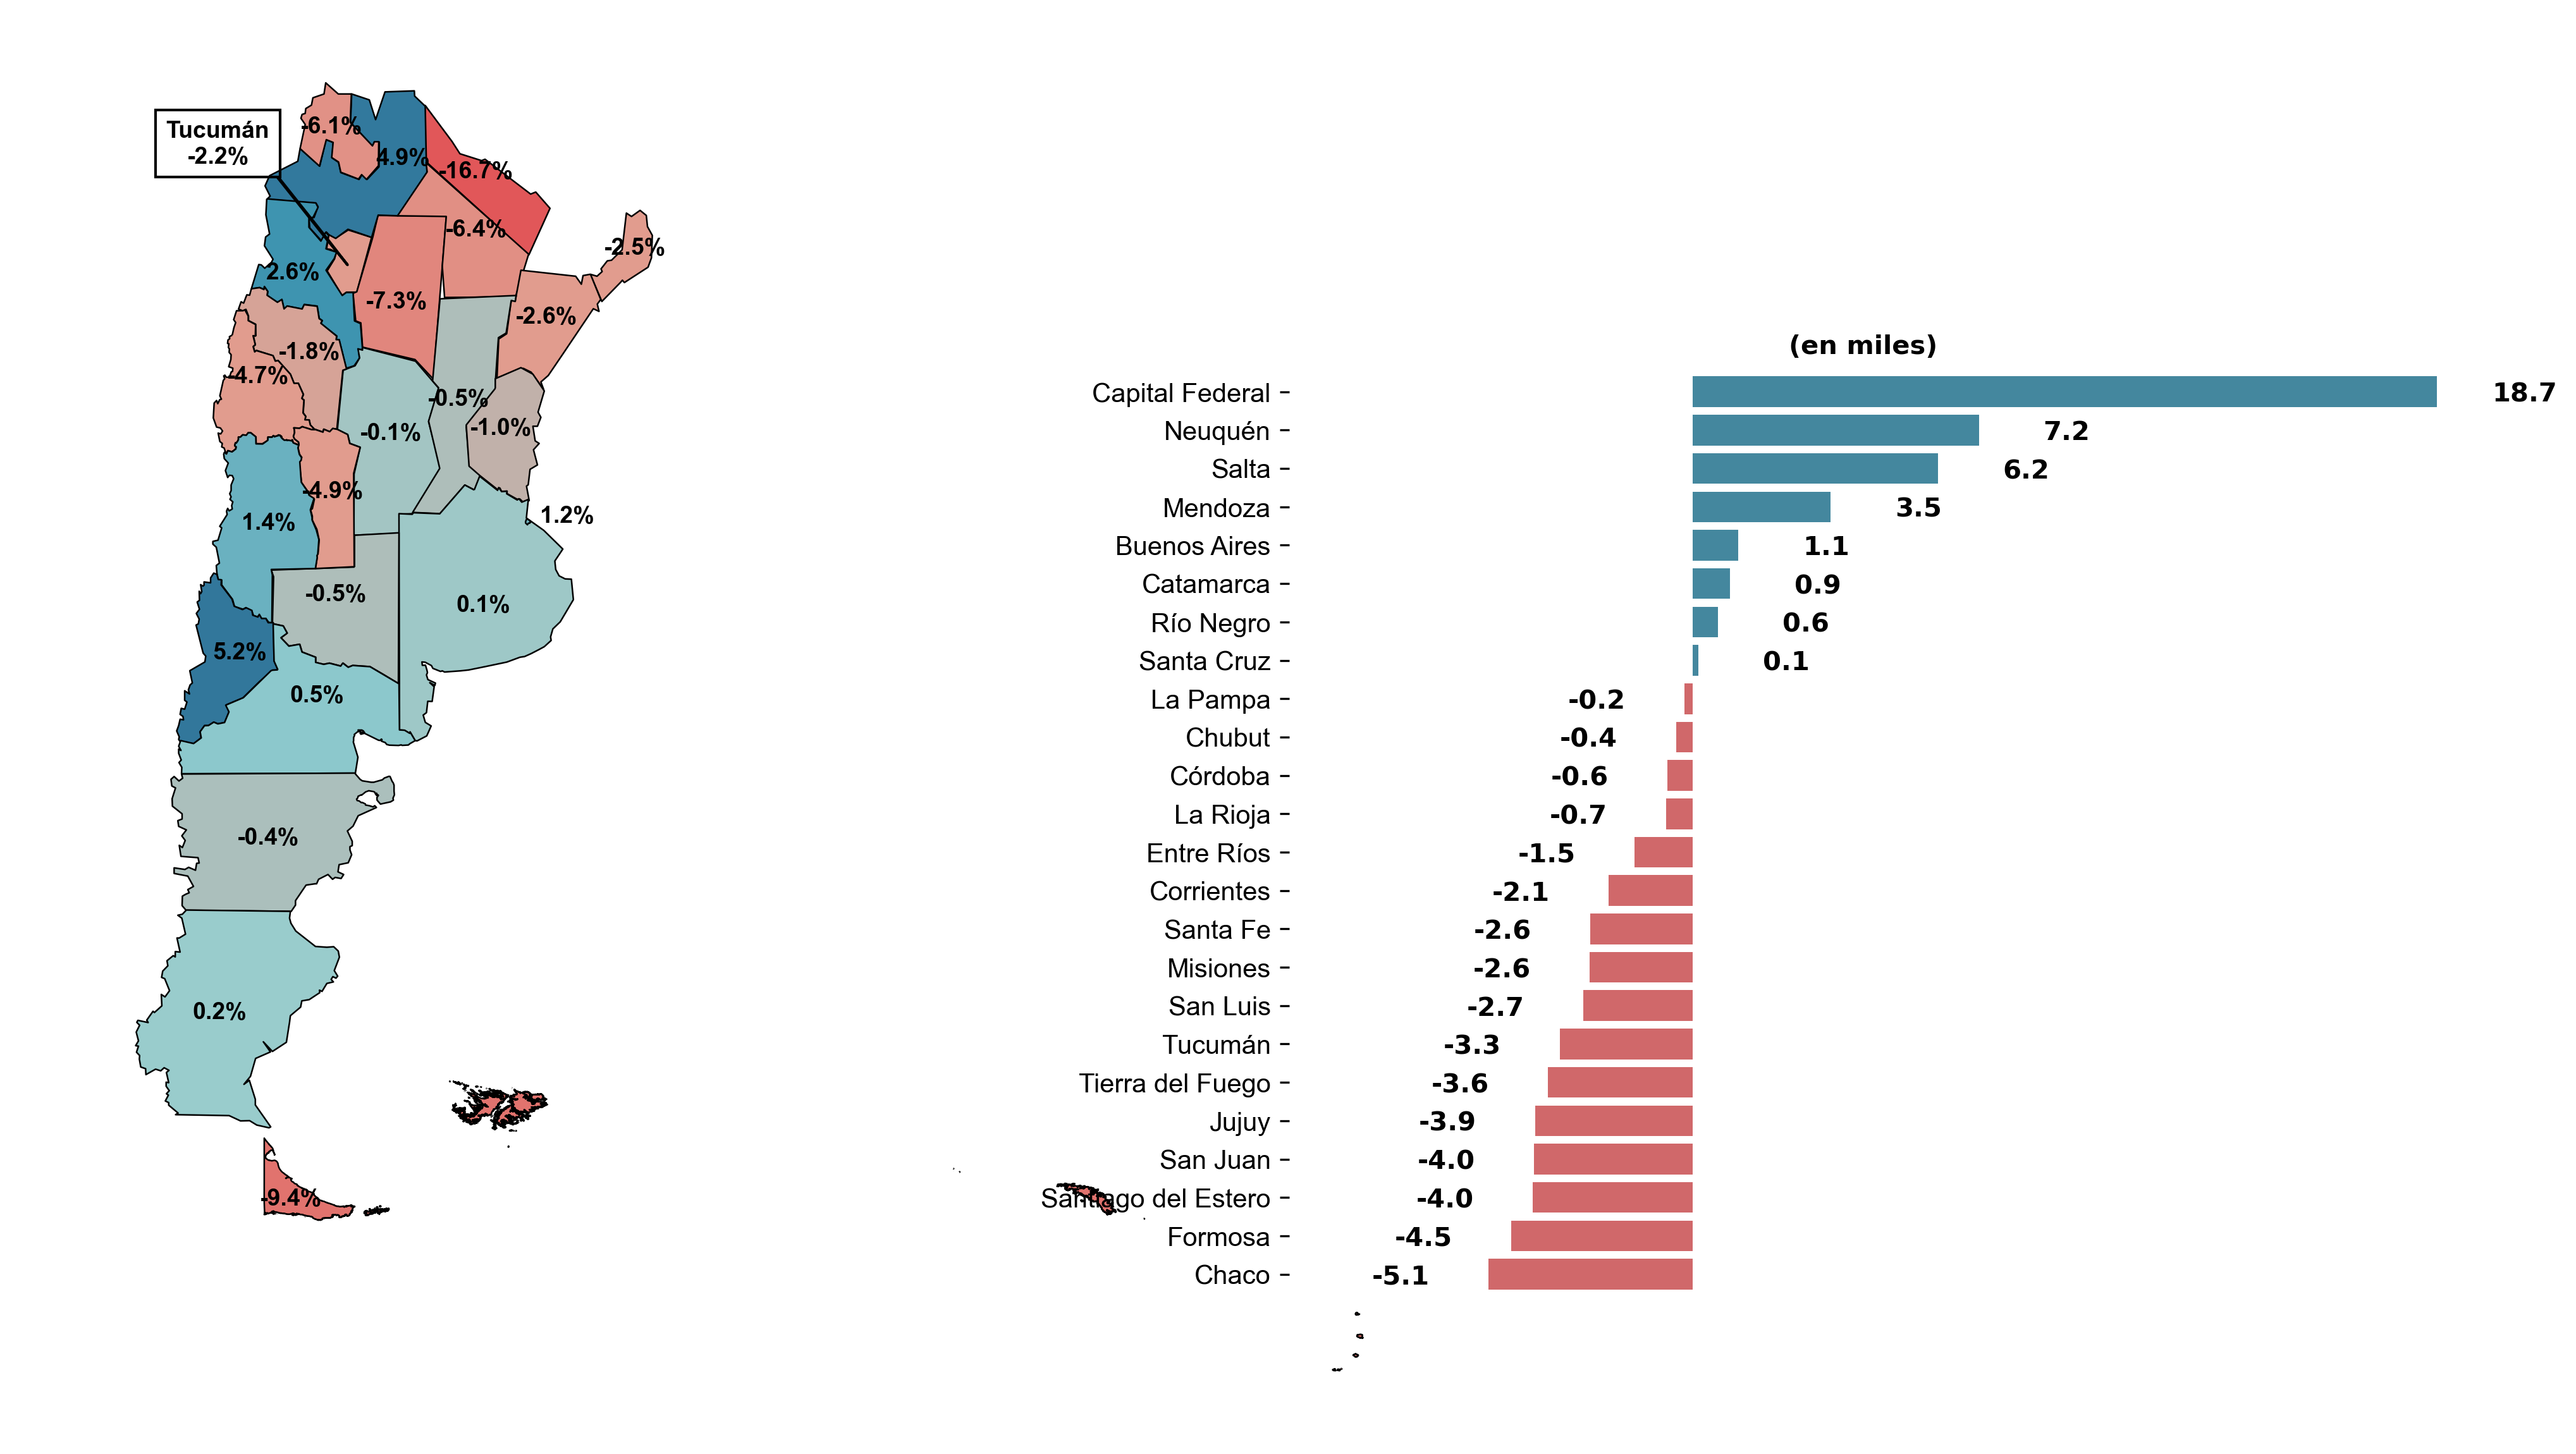

In [8]:
provincias['positivo/negativo'] = provincias['Interanual'] > 0
fig,ax_map= plt.subplots(dpi=300,figsize=(8,8))
# ax = world.clip([-90, -55, -25, 15])
# gs = gridspec.GridSpec(1, 2, width_ratios=[1.6, 1],height_ratios=[1])  # Ratio 1:3 for the two columns

# ax_map = fig.add_subplot(gs[0],)
# ax_map = plt.Axes(fig, [0., 0., 9., 1.])
#Sacar los bordes
# ax_map.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,  labelleft = False, labelbottom = False)
# fig.
ax_map.spines['top'].set_visible(False)
ax_map.spines['right'].set_visible(False)
ax_map.spines['bottom'].set_visible(False)
ax_map.spines['left'].set_visible(False)
# fig.patch.set_visible(False)

provincias.plot(ax=ax_map,column = 'Interanual %',edgecolor = 'black',lw=0.6,cmap = colores_mapa)
ax_map.axes.get_yaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.axis('off')
plt.tight_layout()
ax_map.set_axis_off()
fig.savefig('Graficos/test_map.png',dpi= 300, bbox_inches = 'tight')

provincias['coords'] = provincias['geometry'].apply(lambda x: x.representative_point().coords[:])
provincias['coords'] = [coords[0] for coords in provincias['coords']]
for idx, row in provincias.iterrows():
    annot_params = dict(fontsize = 9, color = 'black', fontweight = 'bold',fontfamily = 'Arial',
                    horizontalalignment='center')
    if row['provincia'] == 'caba':
        xt,yt = row['coords']
        ax_map.annotate(text="{0:.1f}".format(row['Interanual %']*100) + '%',
                        xy=(xt+1.5,yt), **annot_params)
    elif row['provincia'] == 'tucuman':
        xt,yt = row['coords']
        ax_map.annotate(text = 'Tucumán\n' + "{0:.1f}".format(row['Interanual %']*100) + '%',xy = row['coords'],**annot_params,xytext = (xt-5,yt+3),
                        arrowprops={'facecolor':'black','width':0.3,'headwidth':0.3},
                        bbox=dict(facecolor='none', edgecolor='black'))
    elif  row['provincia'] == 'tierra_fuego':
        xt,yt = row['coords']
        ax_map.annotate(text="{0:.1f}".format(row['Interanual %']*100) + '%',
        xy=(xt+0.5,yt-0.75), **annot_params)
        # ax_map.annotate()
    else:
        ax_map.annotate(text="{0:.1f}".format(row['Interanual %']*100) + '%',
                xy=row['coords'], **annot_params)
        # ax_map.annotate()
axins = ax_map.inset_axes([.4,0.2,0.85,0.65])
axins.tick_params(
    axis='x',          
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=False)
axins.tick_params(
    axis='y',          
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=False)
axins.set_xticklabels([])
axins.set_yticklabels([])
# axins.set_xticks([-20,-10,0,10,20])
x_lim_l = provincias['Interanual'].min()-5
x_lim_r = provincias['Interanual'].max()
axins.set_xlim(x_lim_l,x_lim_r)
axins.set_yticks([])
axins.tick_params(axis='y', which='major', labelfontfamily='Arial',labelsize=10)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
axins.spines['bottom'].set_visible(False)
axins.spines['left'].set_visible(False)
a = sns.barplot(provincias,x='Interanual',y='nombre',ax=axins,
            hue='positivo/negativo',palette=['#e15759','#358ead'],dodge=False,
            order=provincias.sort_values('Interanual',ascending=False).nombre)
axins.get_legend().set_visible(False)
axins.set_title(label='(en miles)',
    fontdict = {'fontsize': 10,
 'fontweight' : 'bold',
 'verticalalignment': 'top'},
 y=1.025
)
axins.set(xlabel=None,ylabel=None)
axins.bar_label
# for index, row in provincias.iterrows():
#     plt.text(row.Interanual, row.nombre, str(round(row.Interanual, 2)), color='black', ha="center", fontsize=10, fontweight='bold')
for n,(index, row) in enumerate(provincias.sort_values('Interanual',ascending=False).iterrows()):
    if row.Interanual > 0:
        a.text(row.Interanual+2.2, n+0.25, str(round(row.Interanual, 1)), color='black', ha="center",fontweight='bold')
    else:
        a.text(row.Interanual-2.2, n+0.25, str(round(row.Interanual, 1)), color='black', ha="center",fontweight='bold')
fig.savefig('Graficos/test_map.png',bbox_inches= 'tight')

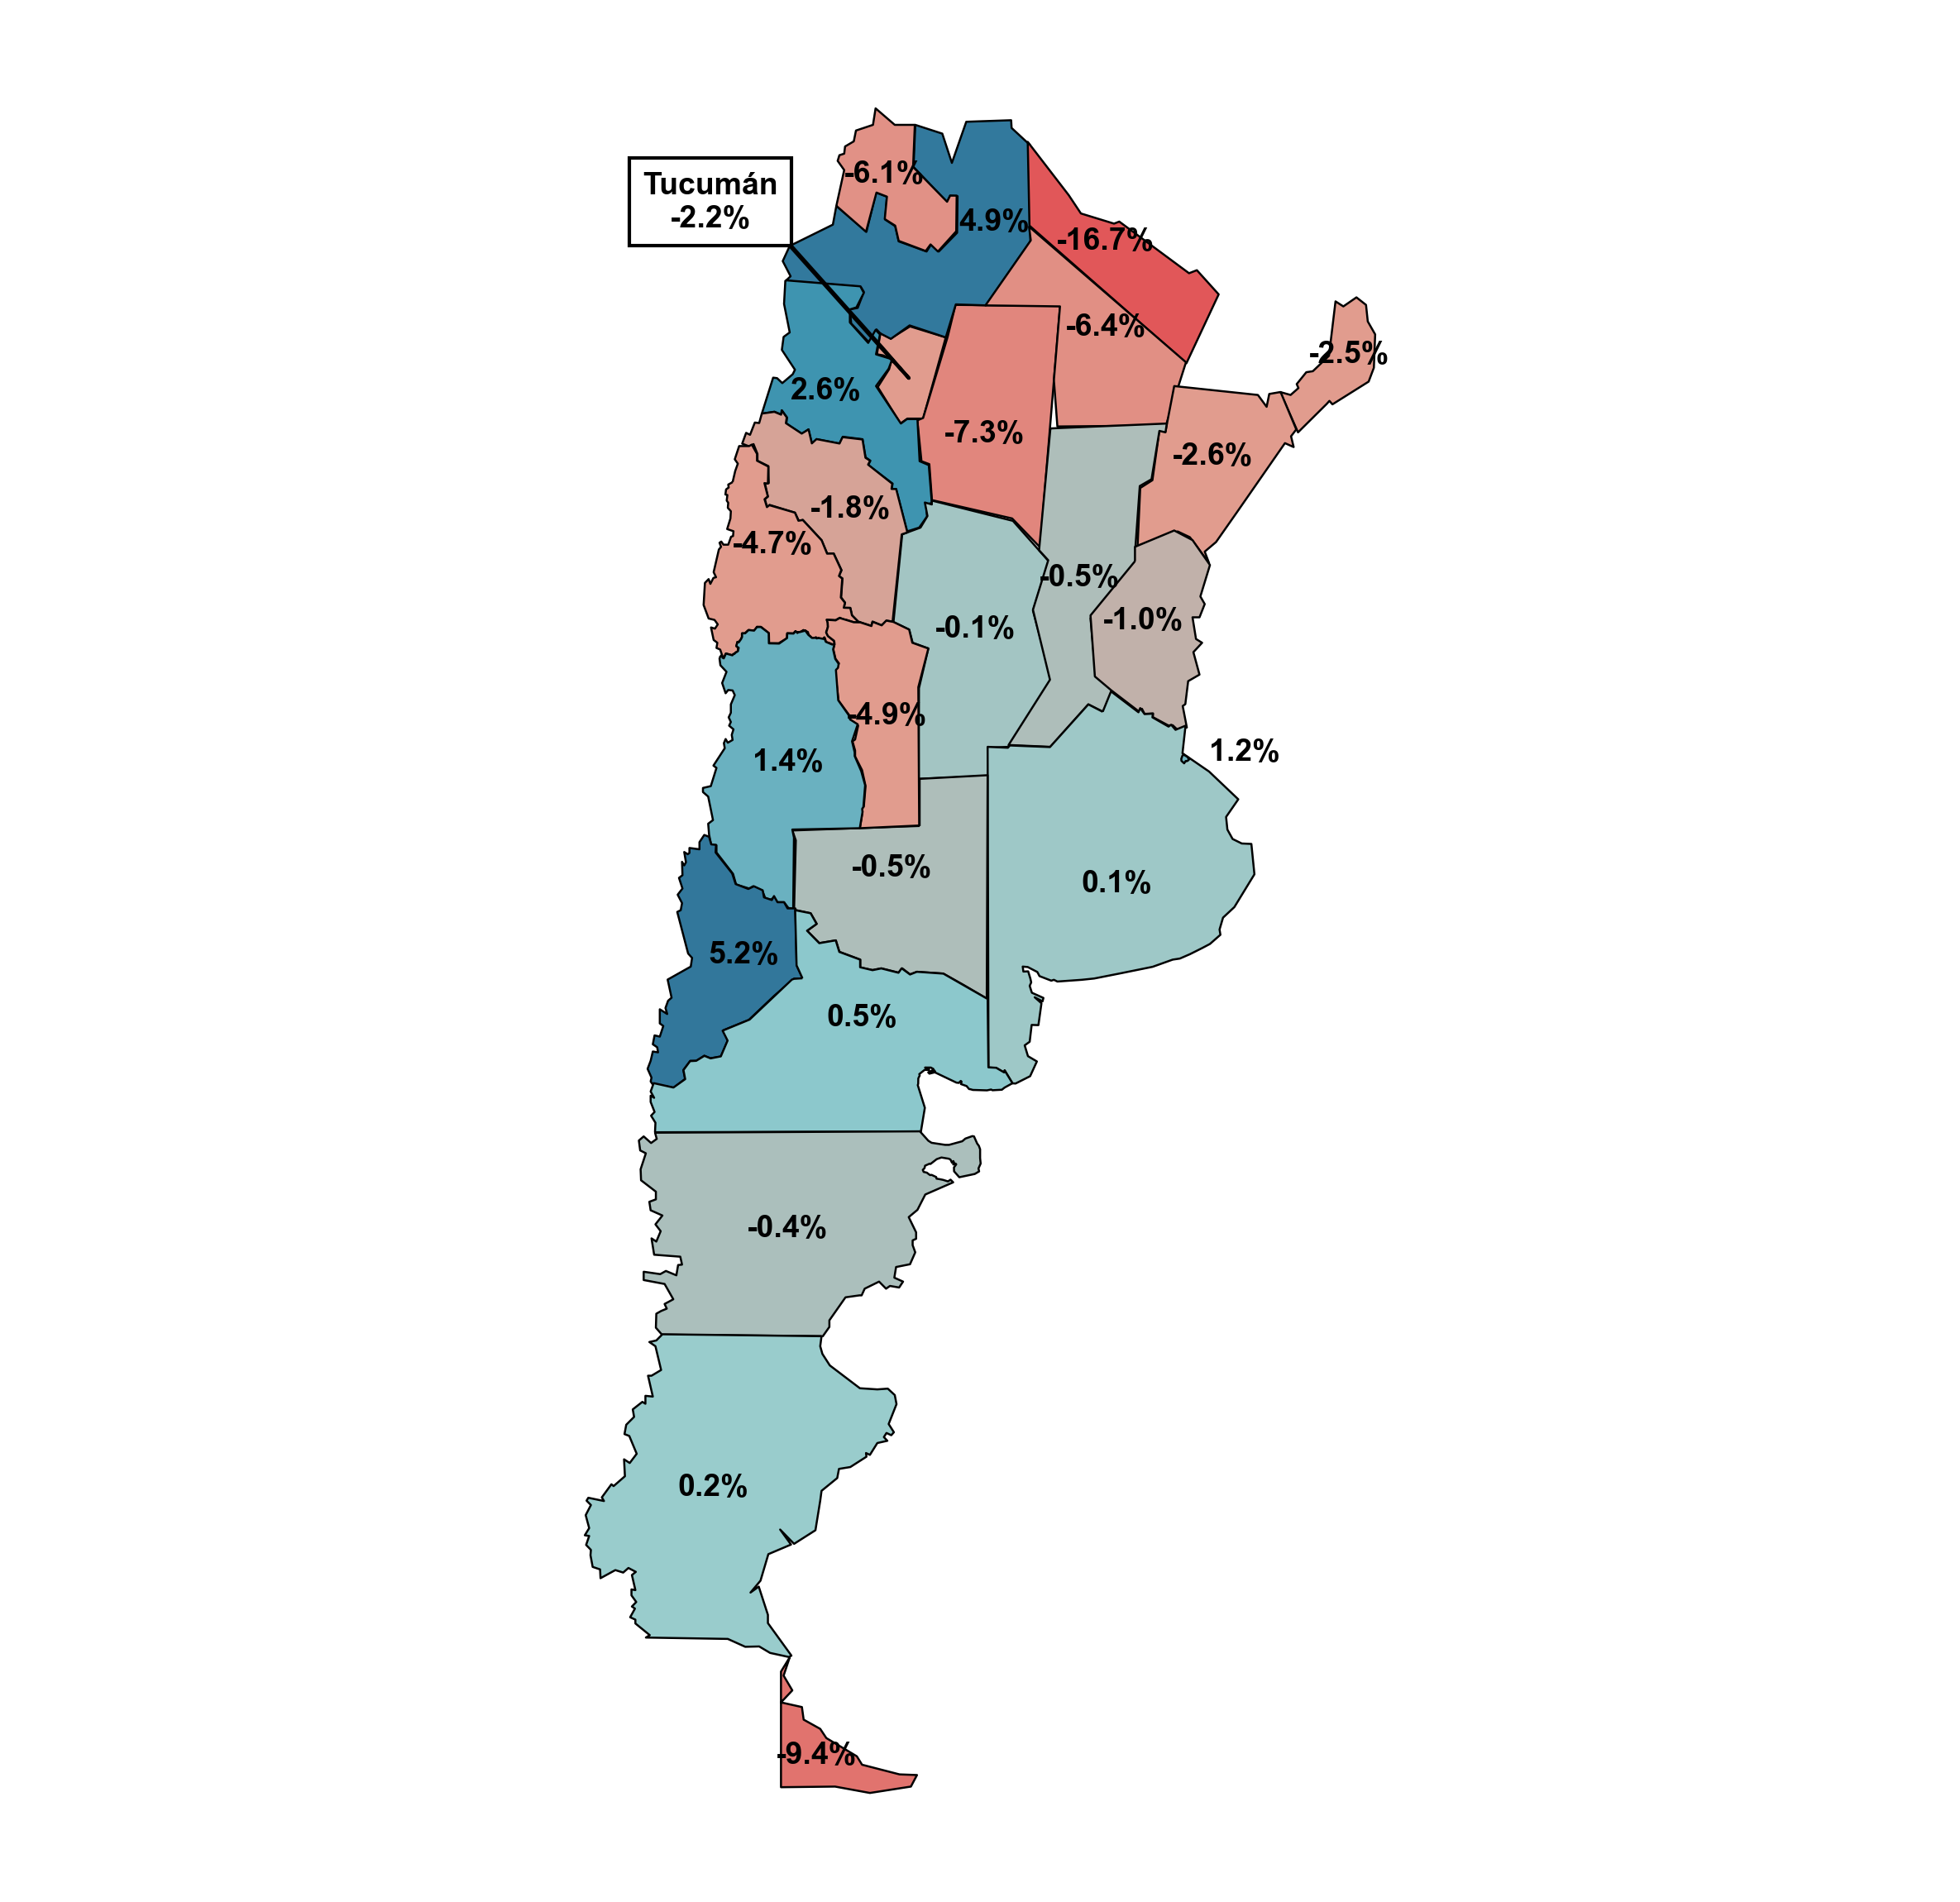

In [92]:
provincias['positivo/negativo'] = provincias['Interanual'] > 0
fig,ax_map = plt.subplots(dpi=300,figsize=(8,8),frameon=False,)
# ax = world.clip([-90, -55, -25, 15])
# ax_map = plt.Axes(fig, [0., 0., 9., 1.])
#Sacar los bordes
# ax_map.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,  labelleft = False, labelbottom = False)
# fig.
ax_map.spines['top'].set_visible(False)
ax_map.spines['right'].set_visible(False)
ax_map.spines['bottom'].set_visible(False)
ax_map.spines['left'].set_visible(False)
# fig.patch.set_visible(False)

provincias.plot(ax=ax_map,column = 'Interanual %',edgecolor = 'black',lw=0.6,cmap = colores_mapa)
ax_map.axes.get_yaxis().set_visible(False)
plt.axes().get_yaxis().set_visible(False)
plt.axis('off')
plt.tight_layout()
ax_map.set_axis_off()
fig.savefig('Graficos/test_map.png',dpi= 300, bbox_inches = 'tight')

provincias['coords'] = provincias['geometry'].apply(lambda x: x.representative_point().coords[:])
provincias['coords'] = [coords[0] for coords in provincias['coords']]
for idx, row in provincias.iterrows():
    annot_params = dict(fontsize = 9, color = 'black', fontweight = 'bold',fontfamily = 'Arial',
                    horizontalalignment='center')
    if row['provincia'] == 'caba':
        xt,yt = row['coords']
        ax_map.annotate(text="{0:.1f}".format(row['Interanual %']*100) + '%',
                        xy=(xt+1.5,yt), **annot_params)
    elif row['provincia'] == 'tucuman':
        xt,yt = row['coords']
        ax_map.annotate(text = 'Tucumán\n' + "{0:.1f}".format(row['Interanual %']*100) + '%',xy = row['coords'],**annot_params,xytext = (xt-5,yt+3),
                        arrowprops={'facecolor':'black','width':0.3,'headwidth':0.3},
                        bbox=dict(facecolor='none', edgecolor='black'))
    elif  row['provincia'] == 'tierra_fuego':
        xt,yt = row['coords']
        ax_map.annotate(text="{0:.1f}".format(row['Interanual %']*100) + '%',
        xy=(xt+0.5,yt-0.75), **annot_params)
        # ax_map.annotate()
    else:
        ax_map.annotate(text="{0:.1f}".format(row['Interanual %']*100) + '%',
                xy=row['coords'], **annot_params)
        # ax_map.annotate()

fig.savefig('Graficos/test_map_solo.png',bbox_inches= 'tight')



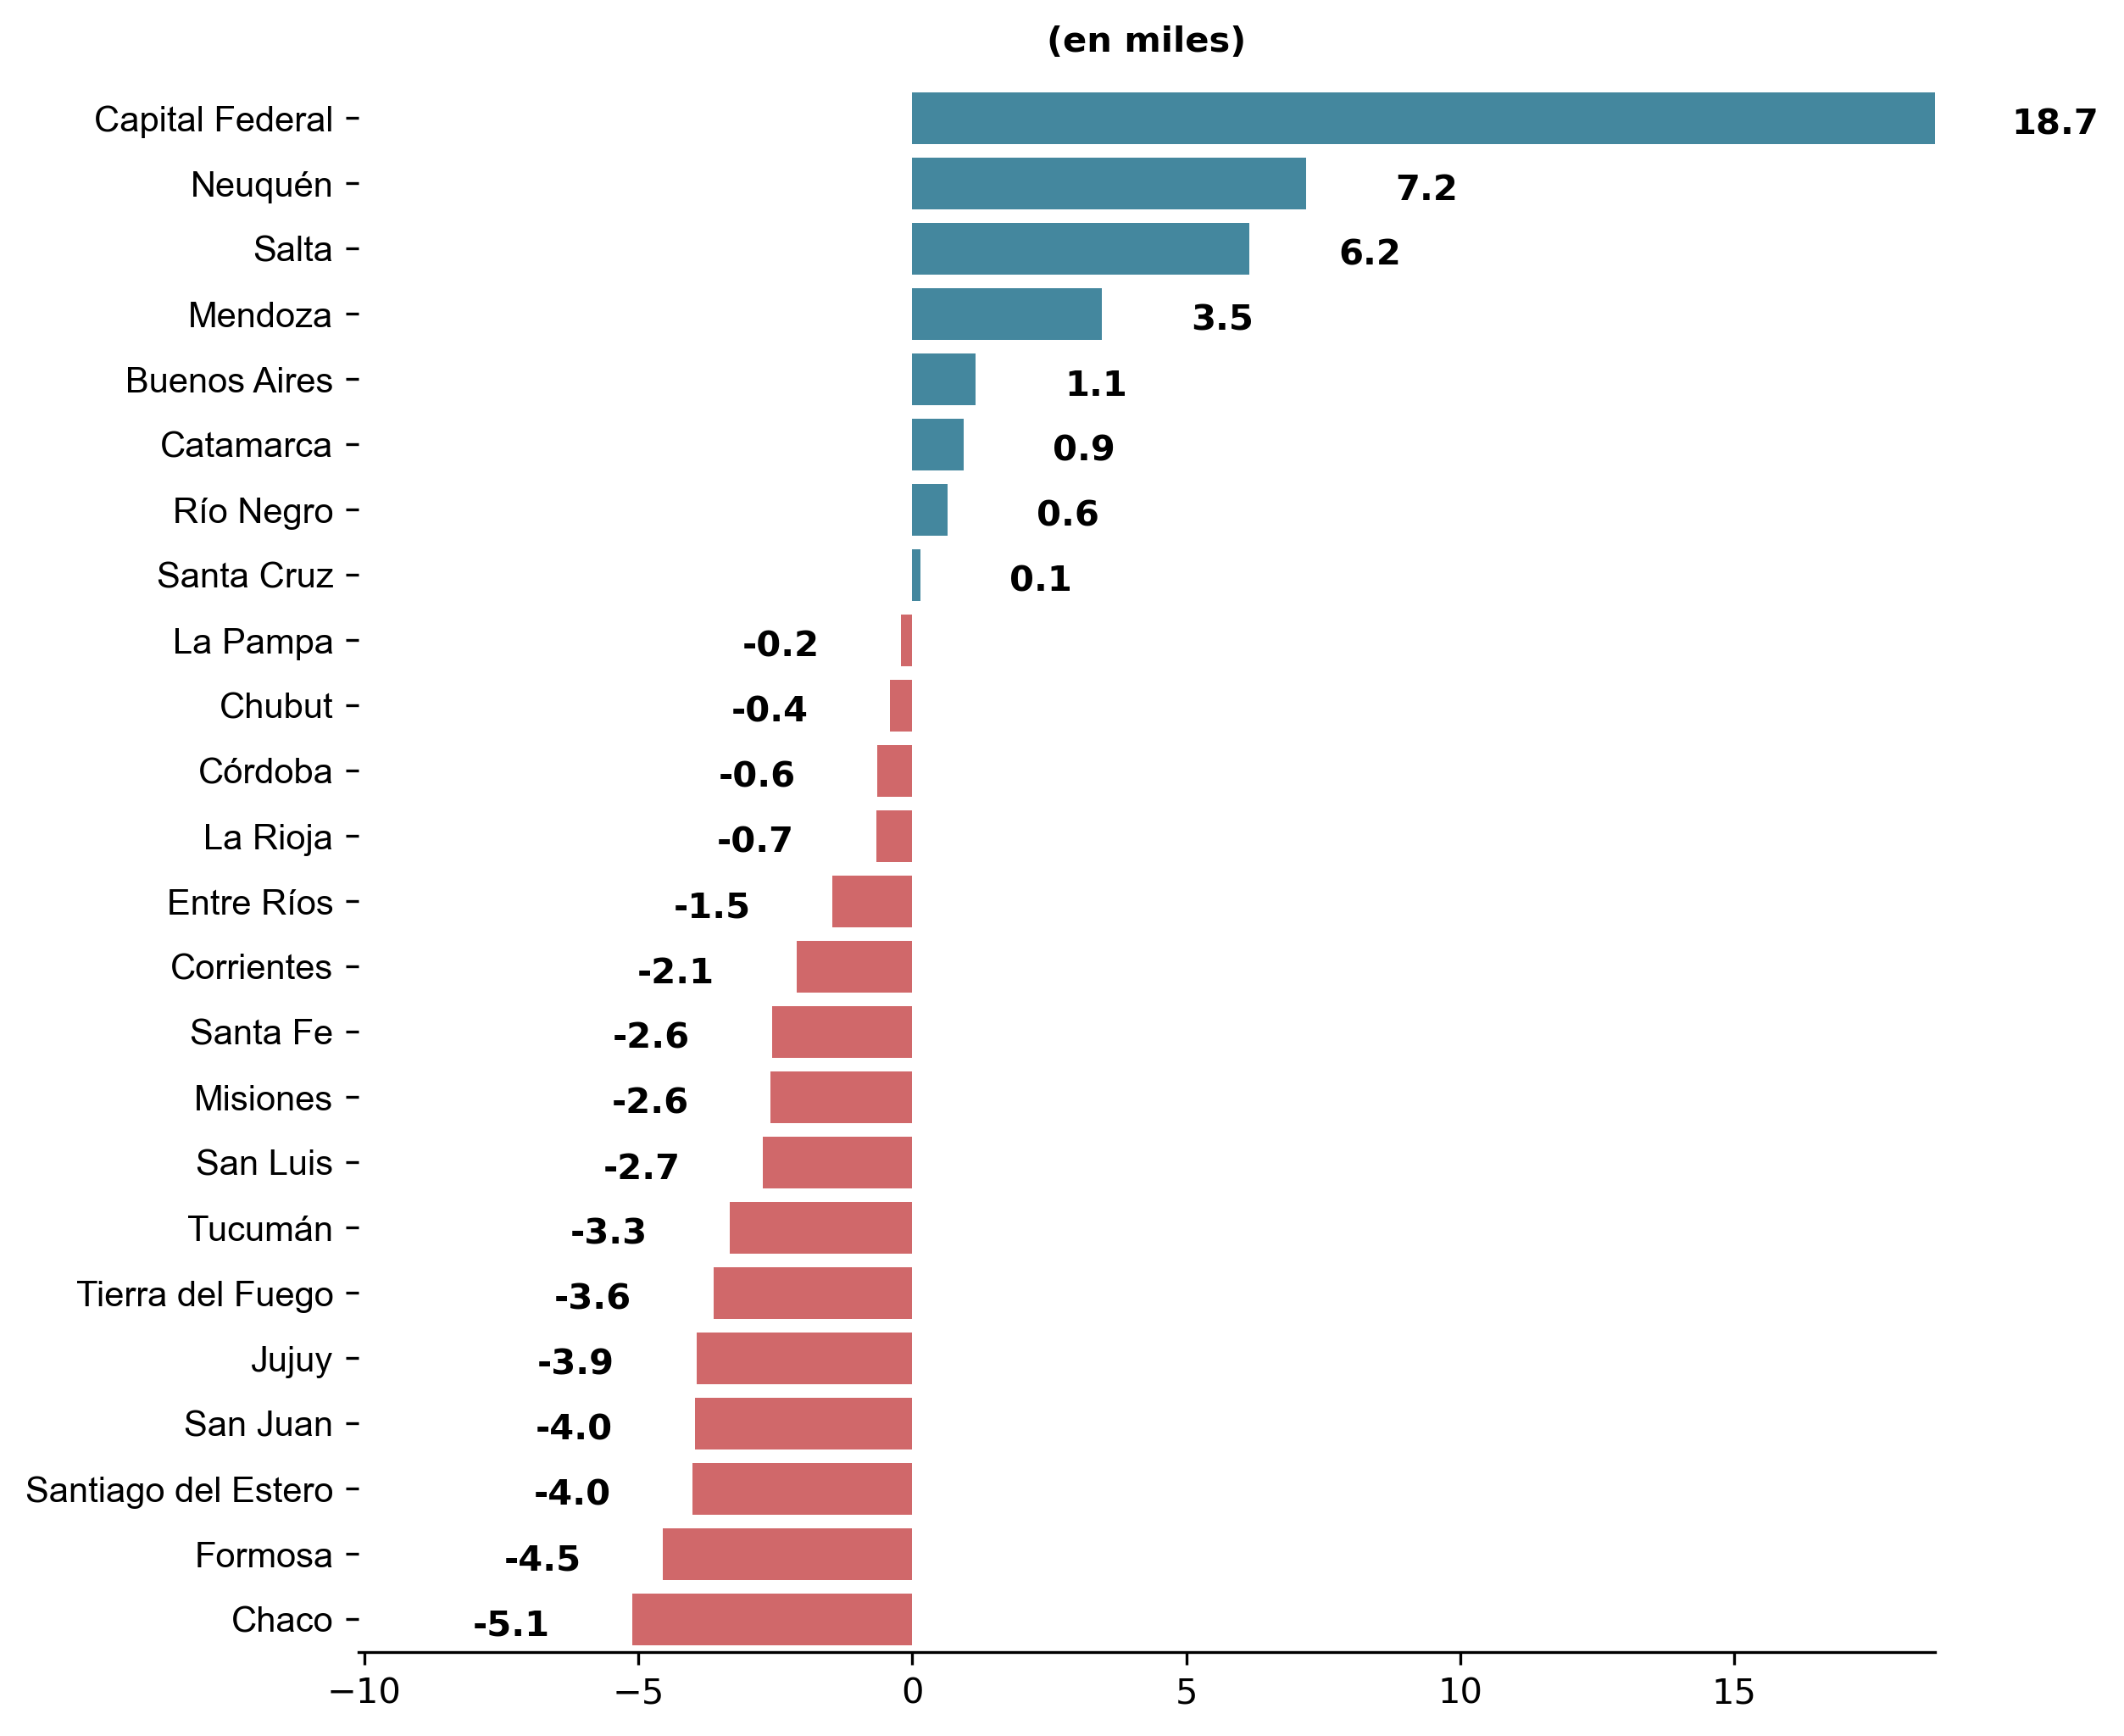

In [93]:
fig,axins = plt.subplots(dpi=300,figsize=(8,8),frameon=False)
# axins.tick_params(
#     axis='x',          
#     which='both',     
#     bottom=False,      
#     top=False,         
#     labelbottom=False)
axins.tick_params(
    axis='y',          
    which='both',     
    bottom=False,      
    top=False,         
    labelbottom=False)
# axins.set_xticklabels([])
axins.set_yticklabels([])
# axins.set_xticks([-20,-10,0,10,20])
x_lim_l = provincias['Interanual'].min()-5
x_lim_r = provincias['Interanual'].max()
axins.set_xlim(x_lim_l,x_lim_r)
axins.set_yticks([])
axins.tick_params(axis='y', which='major', labelfontfamily='Arial',labelsize=10)
axins.spines['top'].set_visible(False)
axins.spines['right'].set_visible(False)
# axins.spines['bottom'].set_visible(False)
axins.spines['left'].set_visible(False)
a = sns.barplot(provincias,x='Interanual',y='nombre',ax=axins,
            hue='positivo/negativo',palette=['#e15759','#358ead'],dodge=False,
            order=provincias.sort_values('Interanual',ascending=False).nombre)
axins.get_legend().set_visible(False)
axins.set_title(label='(en miles)',
    fontdict = {'fontsize': 10,
 'fontweight' : 'bold',
 'verticalalignment': 'top'},
 y=1.025
)
axins.set(xlabel=None,ylabel=None)
axins.bar_label
# for index, row in provincias.iterrows():
#     plt.text(row.Interanual, row.nombre, str(round(row.Interanual, 2)), color='black', ha="center", fontsize=10, fontweight='bold')
for n,(index, row) in enumerate(provincias.sort_values('Interanual',ascending=False).iterrows()):
    if row.Interanual > 0:
        a.text(row.Interanual+2.2, n+0.25, str(round(row.Interanual, 1)), color='black', ha="center",fontweight='bold')
    else:
        a.text(row.Interanual-2.2, n+0.25, str(round(row.Interanual, 1)), color='black', ha="center",fontweight='bold')
axins.set_facecolor('none')
fig.savefig('Graficos/test_bar_maps_solo.png',bbox_inches= 'tight')

In [16]:
provincias

,nombre,geometry
0,Tucumán,"POLYGON ((-66.20361 -26.62782, -66.04980 -26.6..."
1,Santiago del Estero,"POLYGON ((-64.42108 -26.28356, -65.03906 -27.8..."
2,Salta,"POLYGON ((-66.11572 -26.21459, -65.85205 -26.3..."
3,Jujuy,"POLYGON ((-67.22534 -23.69483, -66.47827 -24.2..."
4,Formosa,"POLYGON ((-62.35840 -24.08659, -58.40332 -26.8..."
5,Chaco,"POLYGON ((-61.74316 -27.13737, -61.65527 -28.0..."
6,Misiones,"POLYGON ((-56.04126 -27.37177, -55.59082 -28.1..."
7,Corrientes,"POLYGON ((-56.03027 -27.37177, -56.31592 -27.4..."
8,Catamarca,"POLYGON ((-68.51074 -25.16517, -68.54370 -25.6..."
9,Córdoba,"POLYGON ((-65.56641 -30.18312, -65.78613 -31.9..."


In [47]:
provincias = pd.merge(provincias,interanual,left_on='serie_titulo',right_on='provincia')

In [67]:
provincias['fecha'] = empleo.index[-1]
provincias['Interanual'] = empleo['Interanual_' + provincias['serie_titulo']].iloc[-1]
provincias['Interanual %'] = empleo['Interanual_' + provincias['serie_titulo'] + ' (%)'].iloc[-1]


In [68]:
provincias[['fecha','Interanual','Interanual %']]

,fecha,Interanual,Interanual %
0,2024-01-01,NaN,NaN
1,2024-01-01,NaN,NaN
2,2024-01-01,NaN,NaN
3,2024-01-01,NaN,NaN
4,2024-01-01,NaN,NaN
5,2024-01-01,NaN,NaN
6,2024-01-01,NaN,NaN
7,2024-01-01,NaN,NaN
8,2024-01-01,NaN,NaN
9,2024-01-01,NaN,NaN
